<a href="https://colab.research.google.com/github/Alimv81/emotion_detection_FER2012/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
gpu = tf.config.list_physical_devices('GPU')
if gpu:
  tf.config.experimental.set_memory_growth(gpu[0], True)

In [3]:
url = "https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv"
df = pd.read_csv(url)

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
df_train = df[df['Usage']=='Training'].copy()
df_test = df[df['Usage']=='PublicTest'].copy()
df_valid = df[df['Usage']=='PrivateTest'].copy()

In [7]:
num_classes = 7
input_shape = (48, 48, 1)

def split_data(data):
  data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  images = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
  # images = np.repeat(images, 3, axis=-1) # to make the channels of the image into 3
  labels = data['emotion'].to_numpy()

  return images, labels

In [8]:
train_data, train_labels = split_data(df_train)
test_data, test_labels = split_data(df_test)
validation_data, validation_labels = split_data(df_valid)

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 24, 24, 64)      

In [15]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

In [16]:
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))

lr_scheduler = LearningRateScheduler(lr_schedule)

In [17]:
history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=64, subset="training"),
    epochs=100,
    validation_data=datagen.flow(validation_data, validation_labels, batch_size=64, subset="validation"),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/100
359/359 [==============================] - 31s 41ms/step - loss: 2.2311 - accuracy: 0.1979 - val_loss: 1.8687 - val_accuracy: 0.2538 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 13s 36ms/step - loss: 1.8874 - accuracy: 0.2445 - val_loss: 1.9112 - val_accuracy: 0.2064 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 13s 36ms/step - loss: 1.7304 - accuracy: 0.3074 - val_loss: 1.7496 - val_accuracy: 0.2720 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 13s 37ms/step - loss: 1.5676 - accuracy: 0.3896 - val_loss: 1.8406 - val_accuracy: 0.2259 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 13s 36ms/step - loss: 1.4754 - accuracy: 0.4329 - val_loss: 1.8881 - val_accuracy: 0.3445 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 13s 37ms/step - loss: 1.4093 - accuracy: 0.4585 - val_loss: 1.3614 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 7/100
359/359 [==============================]

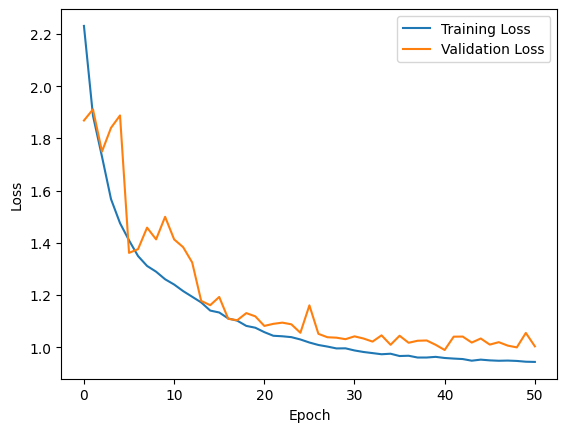

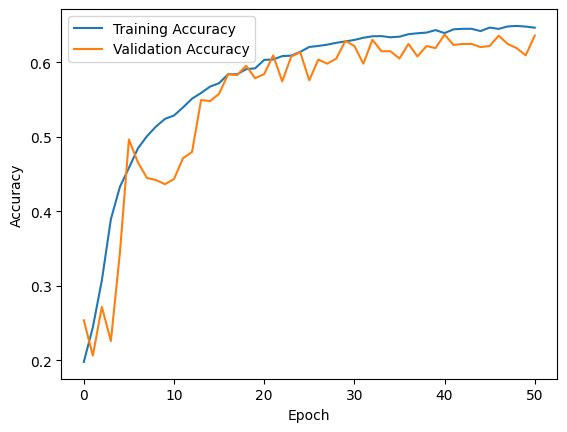

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [20]:
predy = model.predict(test_data)

113/113 [==============================] - 1s 4ms/step


In [21]:
predy[0], np.argmax(predy[0])

(array([0.76702046, 0.0149656 , 0.11519583, 0.00665338, 0.05300357,
        0.00239134, 0.04076988], dtype=float32),
 0)

In [22]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_labels, np.argmax(predy, axis=1)))

0.6271942045137922


In [23]:
idx = [9, 184, 1348, 2834]
image_batch = test_data[idx]
label_batch = test_labels[idx]
label_batch_pred = np.argmax(predy[idx], axis=1)

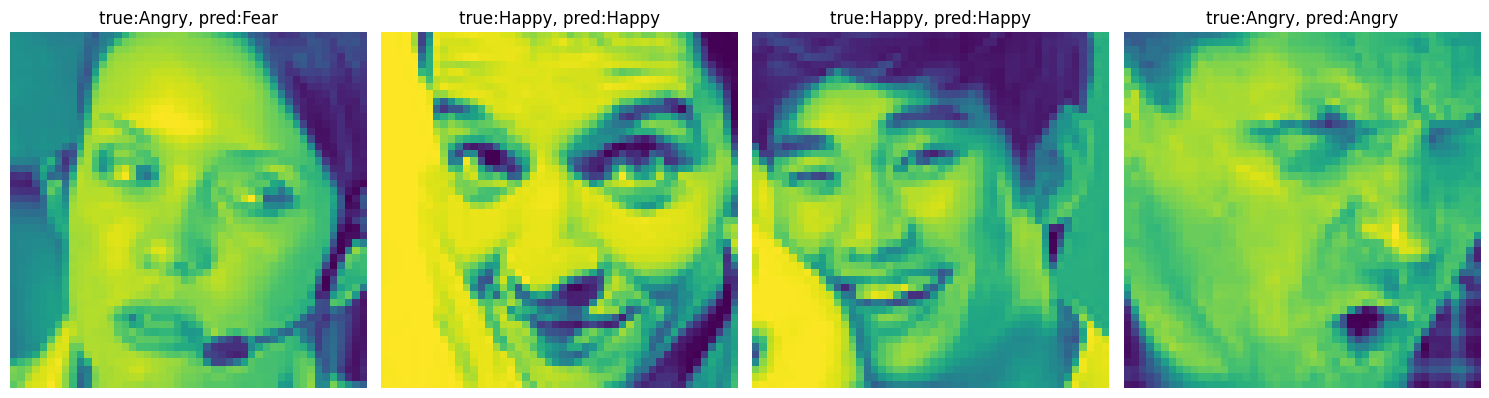

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, ax in enumerate(axes):
    image = image_batch[i]
    ax.imshow(image)
    ax.set_title(f'true:{emotion_map[label_batch[i]]}, pred:{emotion_map[label_batch_pred[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [25]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/File.zip'

In [26]:
with zipfile.ZipFile(path, 'r') as zip_ref:
  zip_ref.extractall('extracted/')

In [27]:
images = []

files_names = os.listdir('extracted/')
for file_name in files_names:
  image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_GRAYSCALE) # use this line if you want image channels number to be 1
  # image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_COLOR) # use this line if you want image channels number to be 3

  image = cv2.resize(image, (48, 48))
  image = image.astype('float32') / 255.0
  image = np.expand_dims(image, axis=-1) # use this line for one channeled images
  images.append(image)

In [28]:
images = np.array(images)
y_hat = np.argmax(model.predict(images), axis=1)

1/1 [==============================] - 0s 209ms/step


In [29]:
images.shape

(11, 48, 48, 1)

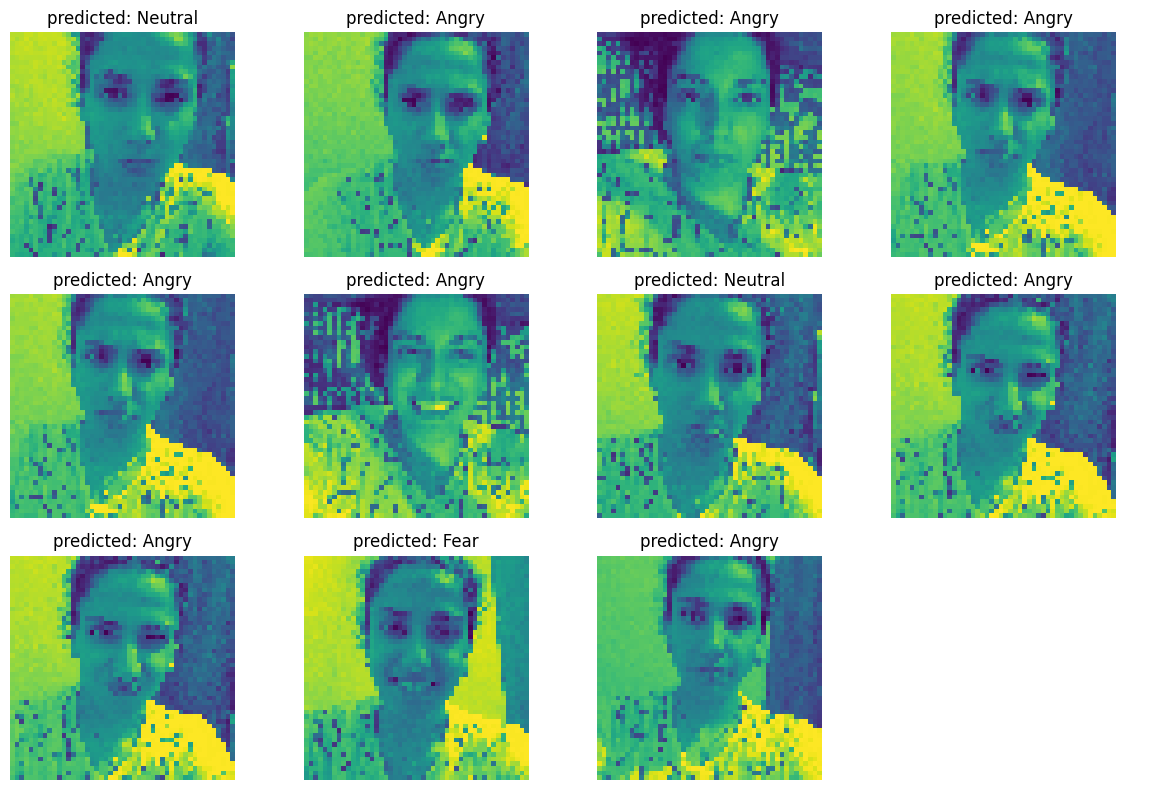

In [30]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i in range(3):
  for j in range(4):
    ax = axes[i][j]
    if i!=2 or j!=3:
      ax.imshow(images[i*3 + j])
      ax.set_title(f'predicted: {emotion_map[y_hat[i*3 + j]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()